# Bulk groupshift analysis

In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [36]:
import numpy as np
import pickle
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from groupshift_parallel import *

Key: 
* SCOPE - Function defining scope of information
* GLEAN - Function defining reaction to information
* SHIFT - Function defining intergroup perception changes
* "attract" - uses attraction equation for GLEAN
* "nn" - not normalized, modifier for "attract"
* "norm" - normalized modifier for "attract"
* "sampling" - SCOPE doesn't account for full ingroup
* "repulse" - reverse attraction for SHIFT
* "means" - ???

In [2]:
simfol_list = ["attract_nn_high", "attract_nn_low_repulse", "attract_norm_low", "sampling_attract_repulse", "attract_nn_high_repulse", "attract_norm_high", 
"attract_norm_low_repulse", "sampling_means", "attract_nn_low", "attract_norm_high_repulse", "sampling_attract", "sampling_means_repulse"]

## Load single sim

/l/nx/data/groupshift/trial1_july4_2025/aWidth5_aAmp0.5_rWidth10_rAmp0.0/simulation1.pkl


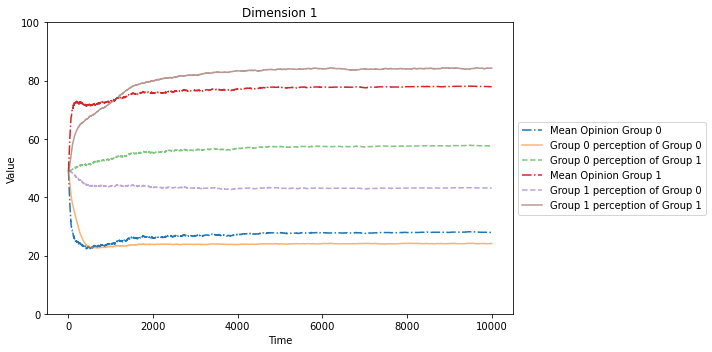

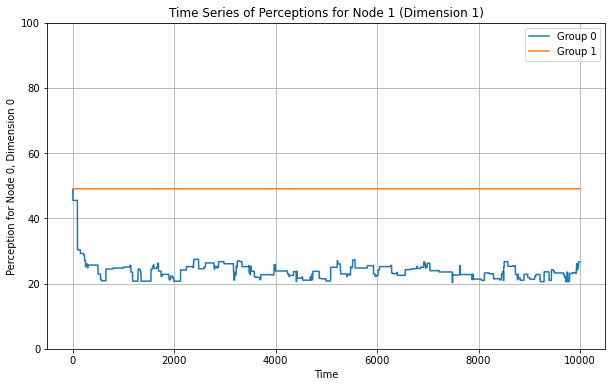

In [ ]:
aWidth = 1.0
rWidth = 1.0
aAmp = 1.0
rAmp = 1.0

parameter_label = f"aWidth{aWidth}_aAmp{aAmp}_rWidth{rWidth}_rAmp{rAmp}"
# simtype = "sample10_lagmean20"
simtype = parameter_label
trial_folder = "sims_2025_12_17_initmeans"
folder = f"/l/nx/data/groupshift/{trial_folder}/{simtype}"
filename = os.listdir(folder)[1]
print( folder + "/" + filename )

with open(folder+"/"+filename, 'rb') as f:
    singlesim = pickle.load(f)

singlesim.plot_group_values()
singlesim.plot_indiv_values(node_num=0)

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation0.pkl


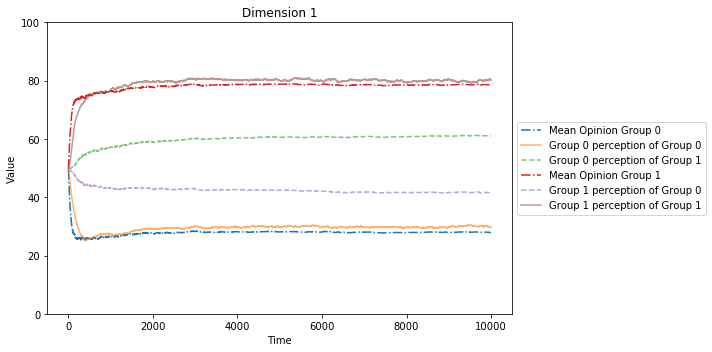

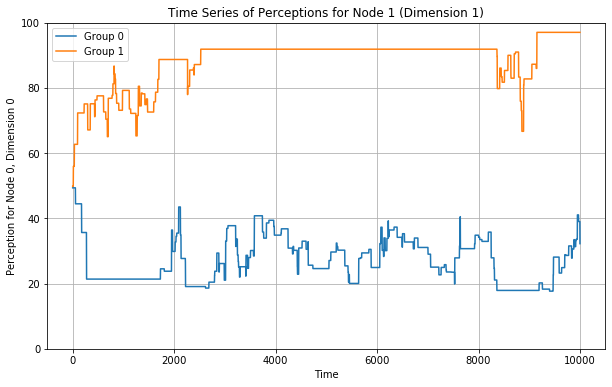

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation1.pkl


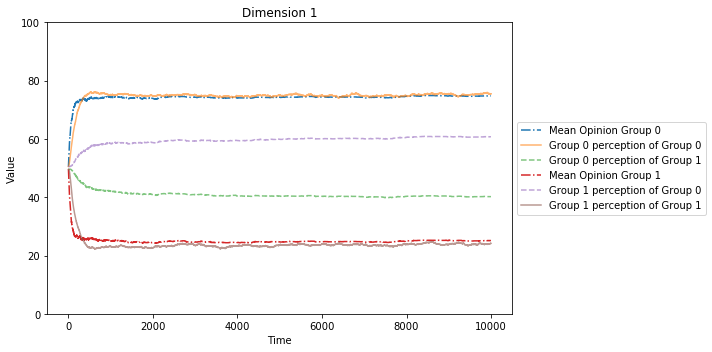

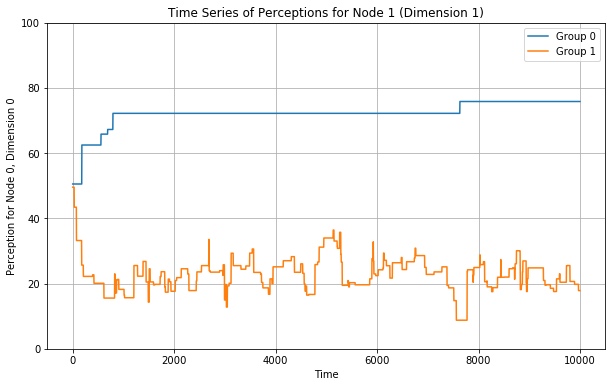

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation2.pkl


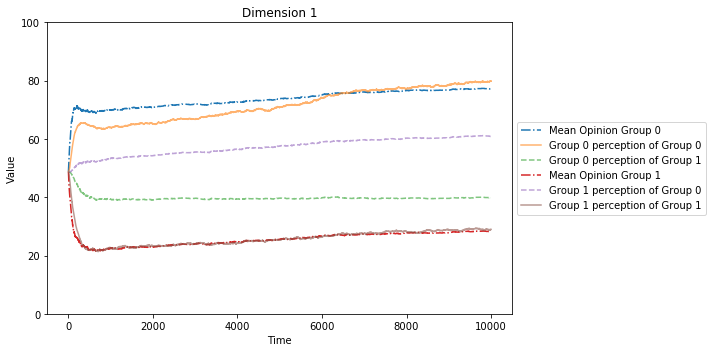

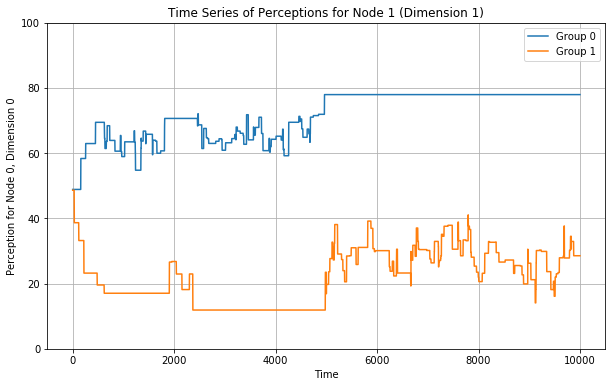

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation3.pkl


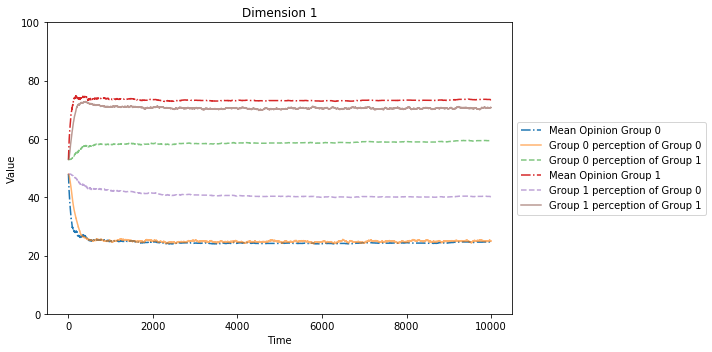

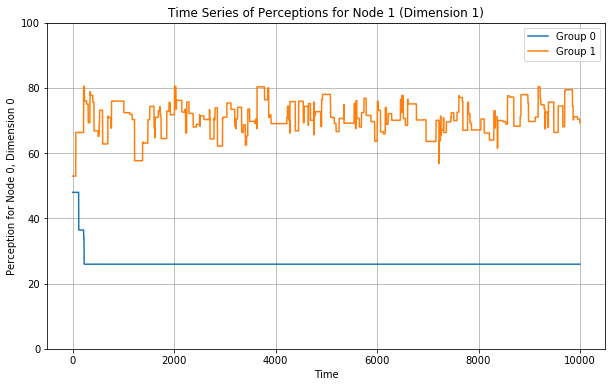

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation4.pkl


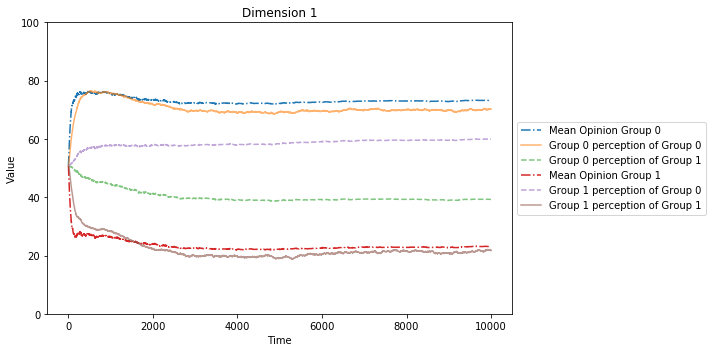

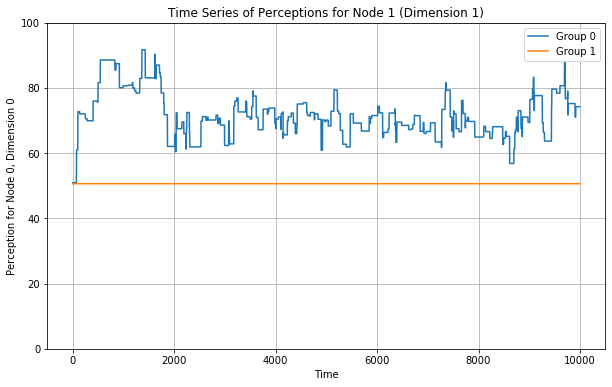

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation5.pkl


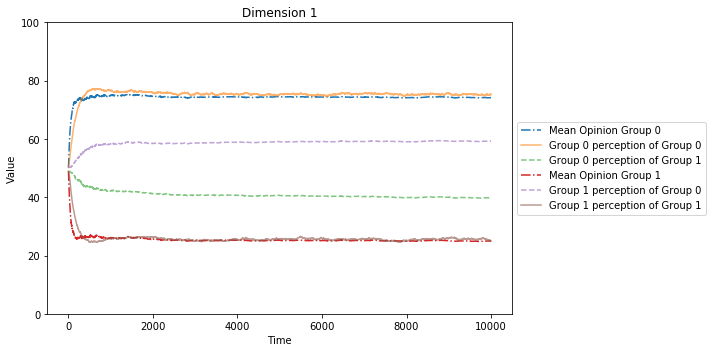

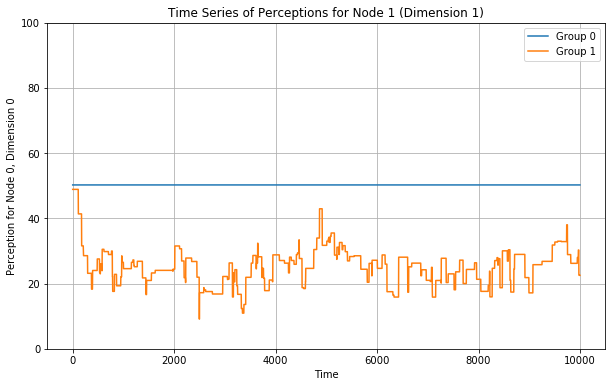

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation6.pkl


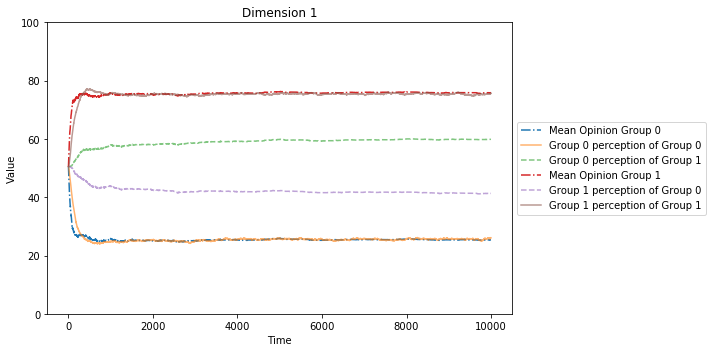

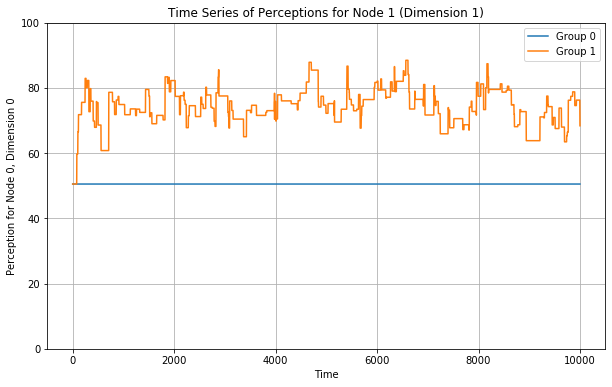

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation7.pkl


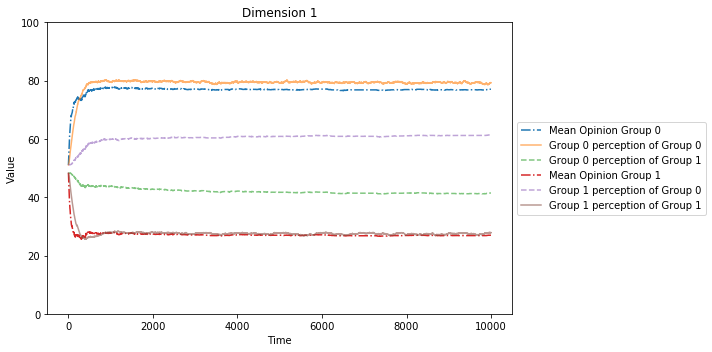

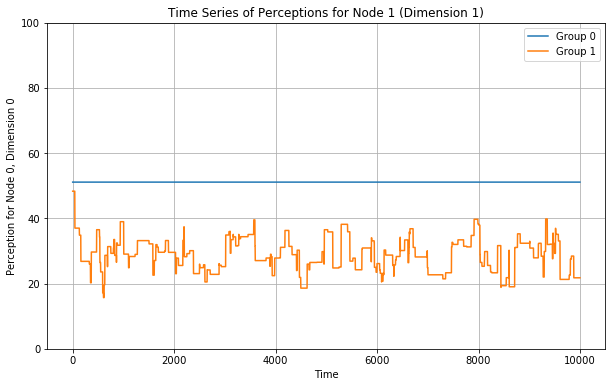

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation8.pkl


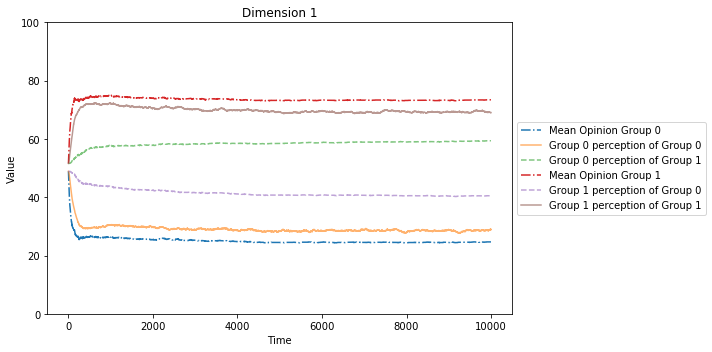

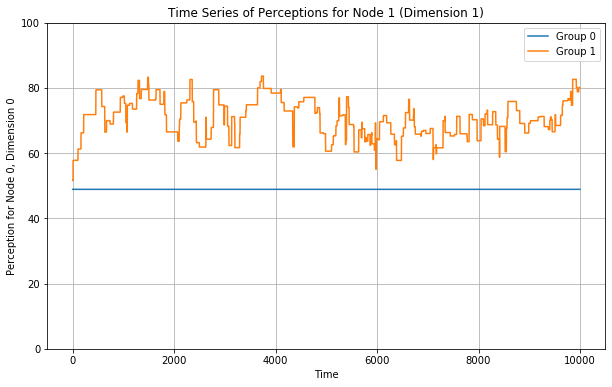

/l/nx/data/groupshift/trial6_oct18/sampling_attract/simulation10.pkl


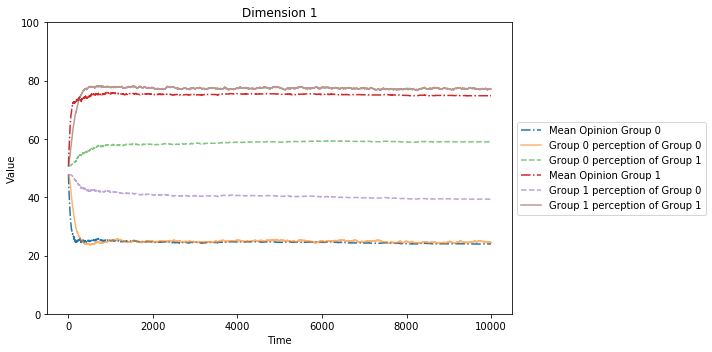

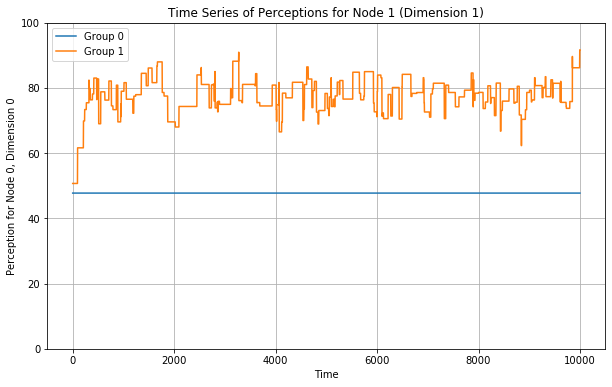

In [13]:
#Plot multiple simulations of the same type

for simnum in range(10):
    simtype = "sampling_attract"
    trial_folder = "trial6_oct18"
    folder = f"/l/nx/data/groupshift/{trial_folder}/{simtype}"
    filename = os.listdir(folder)[simnum]
    print( folder + "/" + filename )

    with open(folder+"/"+filename, 'rb') as f:
        singlesim = pickle.load(f)

    singlesim.plot_group_values()
    singlesim.plot_indiv_values(node_num=0)

attract_nn_high


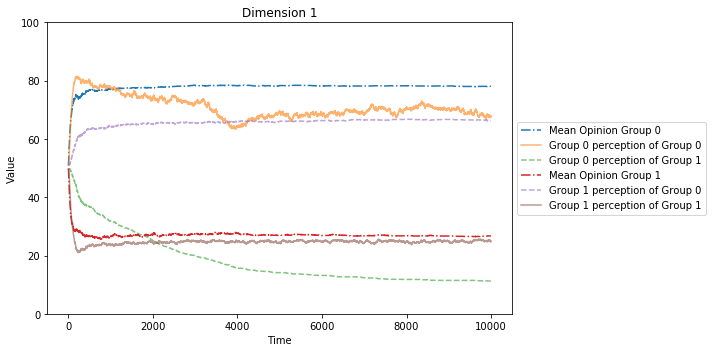

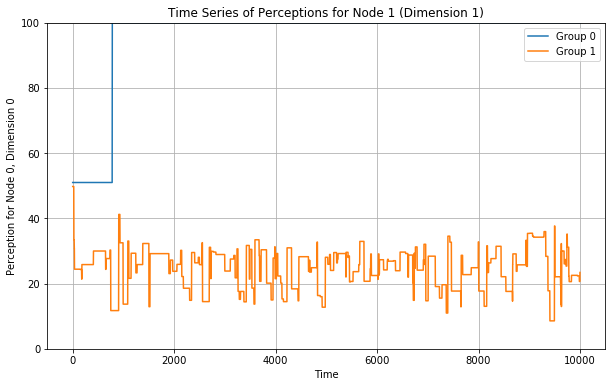

attract_nn_low_repulse


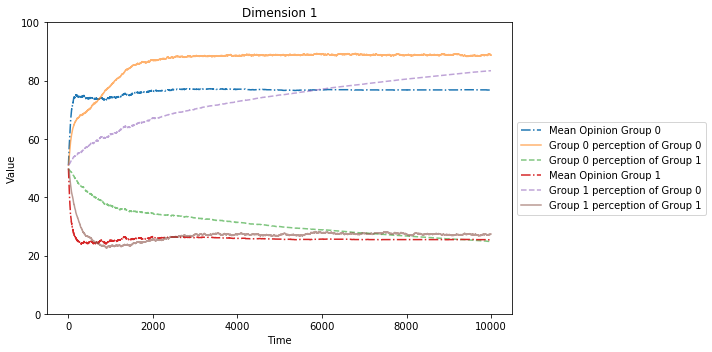

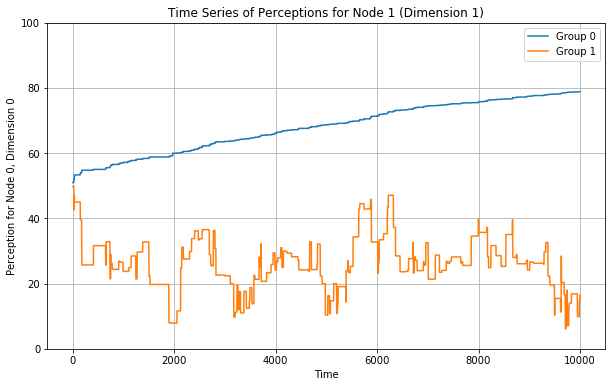

attract_norm_low


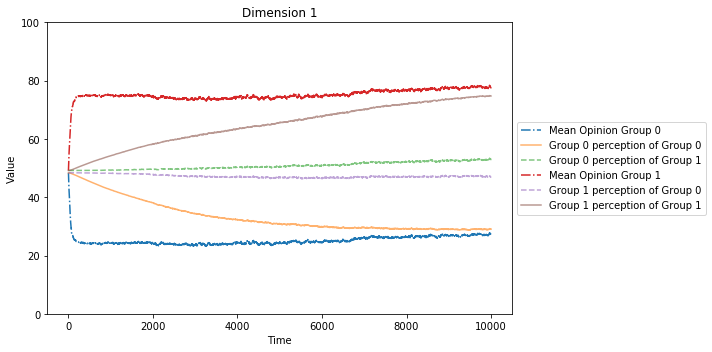

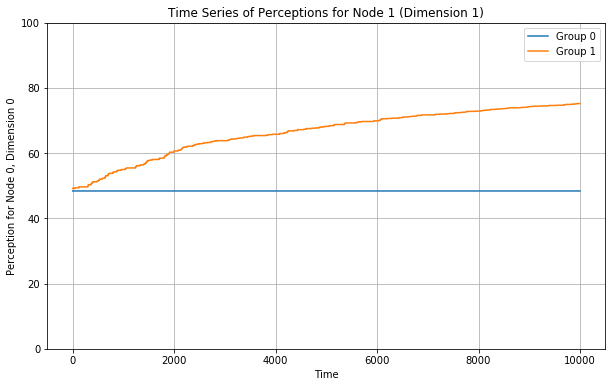

sampling_attract_repulse


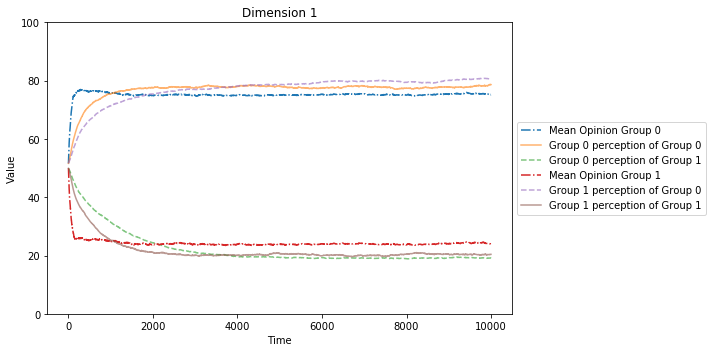

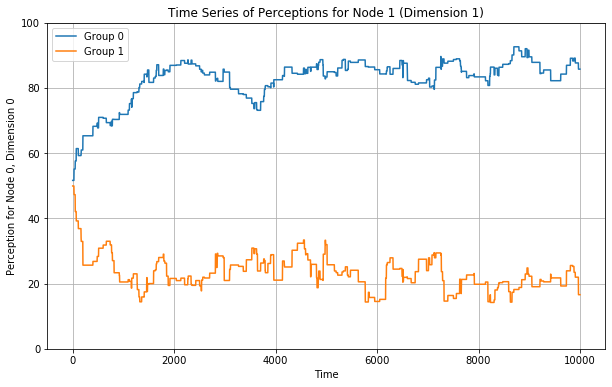

attract_nn_high_repulse


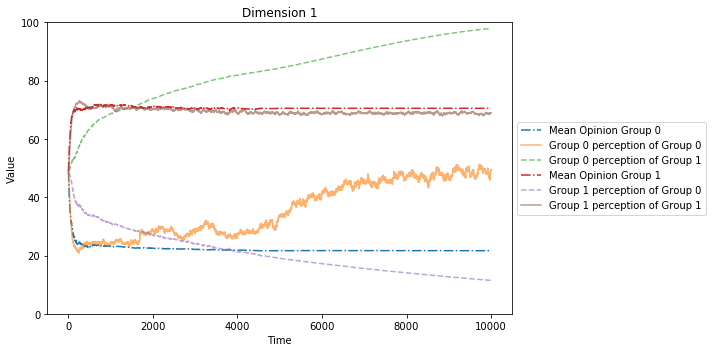

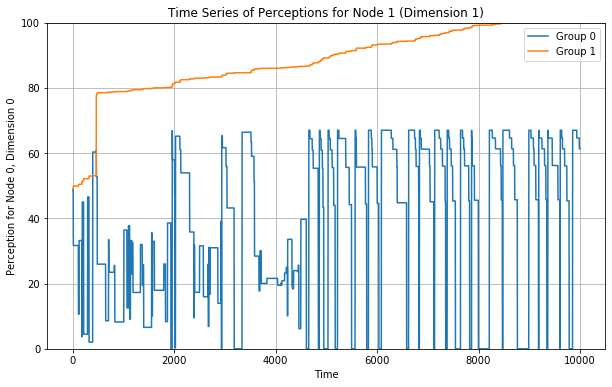

attract_norm_high


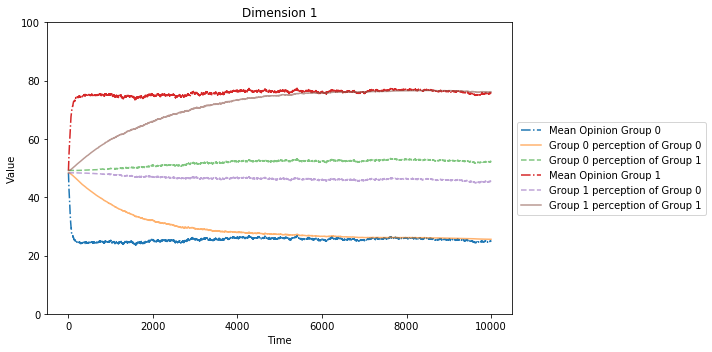

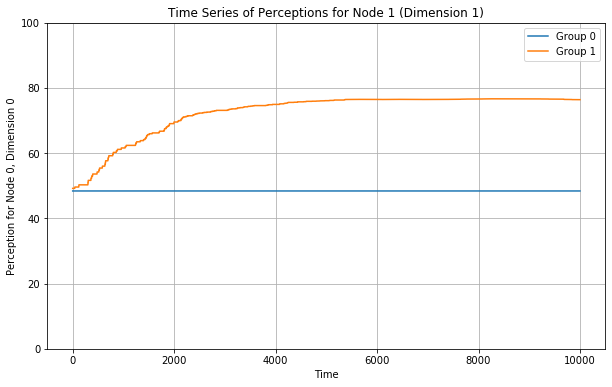

attract_norm_low_repulse


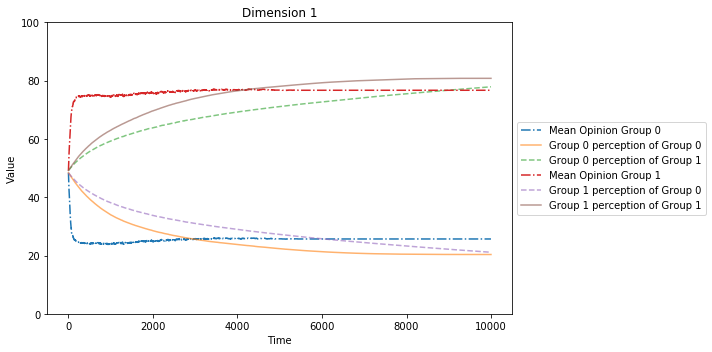

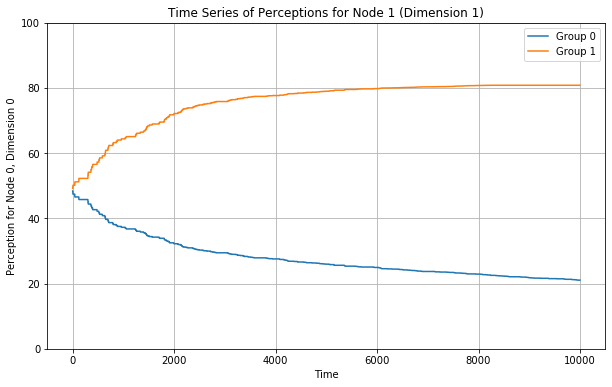

sampling_means


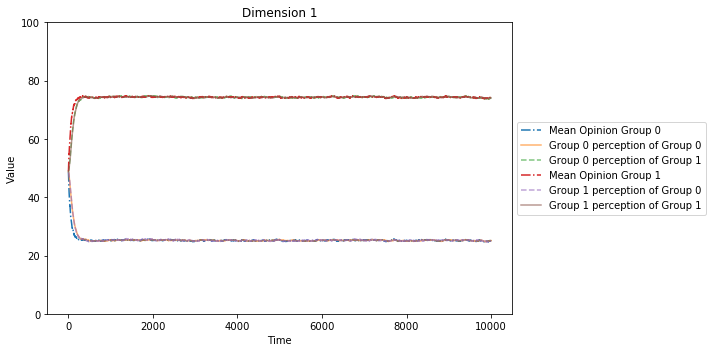

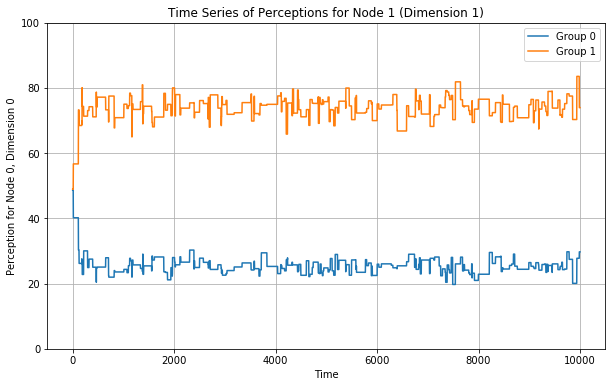

attract_nn_low


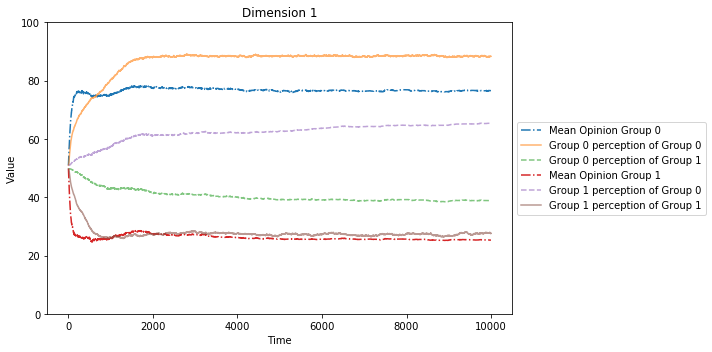

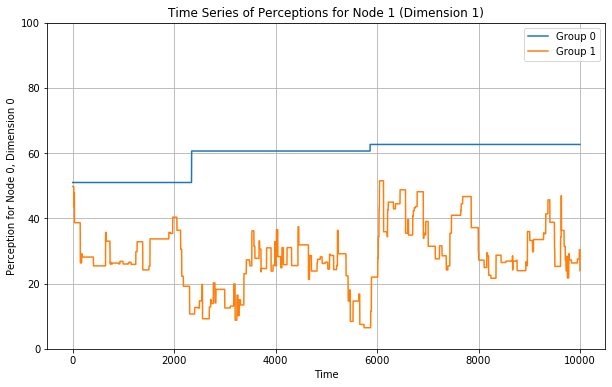

attract_norm_high_repulse


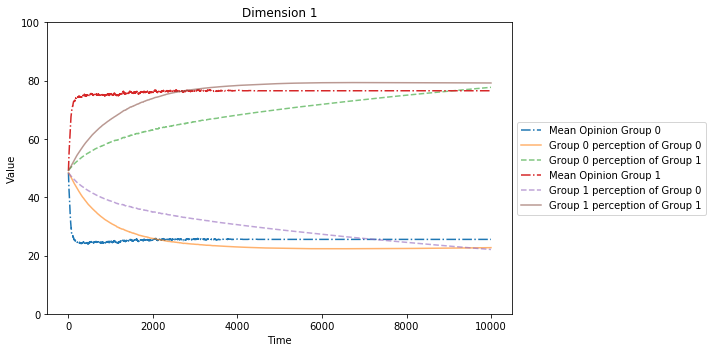

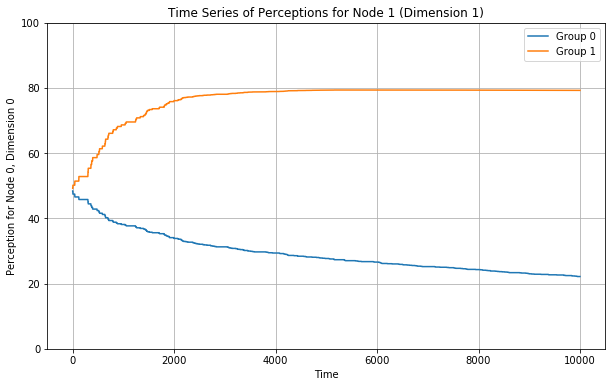

sampling_attract


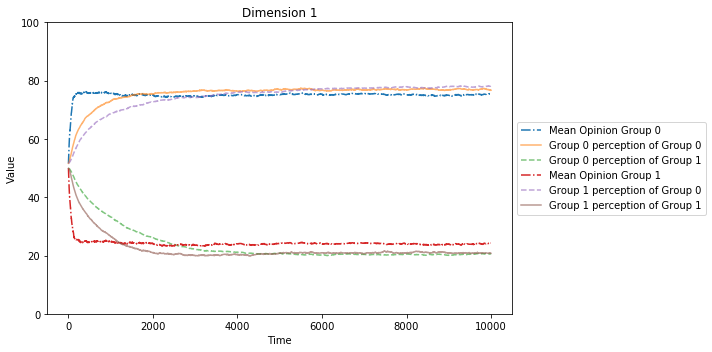

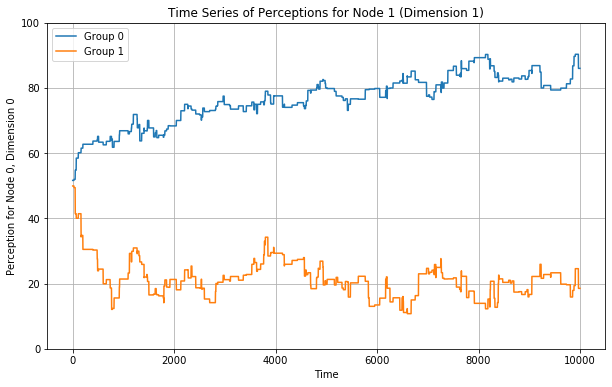

sampling_means_repulse


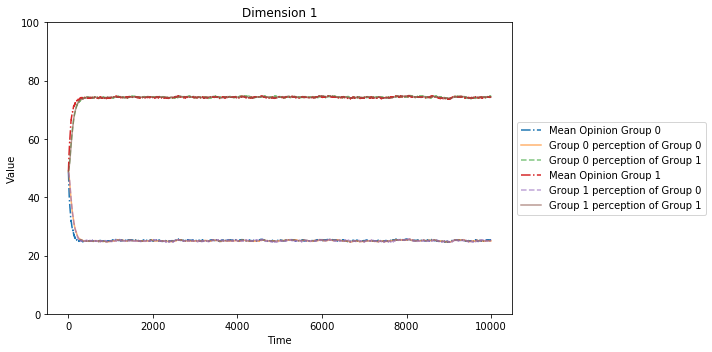

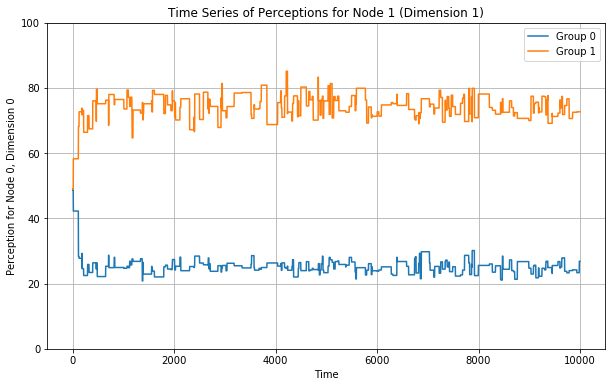

In [6]:
for fol in simfol_list:
    print(fol)
    folder = f"/l/nx/data/groupshift/{trial_folder}/{fol}"
    filename = os.listdir(folder)[0]

    with open(folder+"/"+filename, 'rb') as f:
        singlesim = pickle.load(f)

    singlesim.plot_group_values()
    singlesim.plot_indiv_values(node_num = 0)

## Load and calculate

General setup:
* Define the set of simulations for the question
* Get the data from all those simulations
* Run calculations for each simulation
* Put calculations into dataframe
* Save dataframe

Folders:
* "attract_nn_high"
* "attract_nn_low_repulse"
* "attract_norm_low"
* "sampling_attract_repulse"
* "attract_nn_high_repulse"
* "attract_norm_high"
* "attract_norm_low_repulse"
* "sampling_means"
* "attract_nn_low"
* "attract_norm_high_repulse"
* "sampling_attract"
* "sampling_means_repulse"


In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

from groupshift_parallel import *

In [6]:
#simfol_list = ["attract_nn_high", "attract_nn_low_repulse", "attract_norm_low", "sampling_attract_repulse", "attract_nn_high_repulse", "attract_norm_high", "attract_norm_low_repulse", "sampling_means", "attract_nn_low", "attract_norm_high_repulse", "sampling_attract", "sampling_means_repulse"]
#trial_folder = "trial5_oct11"

#simfol_list = [ "sampling_means",  "sampling_means_repulse",  "sampling_attract",  "sampling_attract_repulse",  "sampling_attract_woutgroup",  "sampling_attract_repulse_woutgroup",  "attract_nn_mid",  "lagmean_only",  "sampling_lagmean",  "sampling_lagmean_repulse"]
#trial_folder = "trial6_oct18"

simfol_list = [
    "lagmean_only",
    "sample100_lagmean50",
    "sample100_lagmean20",
    "sample100_lagmean01",
    "sample10_lagmean50",
    "sample10_lagmean20",
    "sample10_lagmean01"
]
trial_folder = "trial8_may7_2025"

folder = f"/l/nx/data/groupshift/{trial_folder}/"

In [7]:
def calcPlurg2Scatter(G, N, N_adj, num_timesteps_to_average = 500, dim = 0):
	# Get the number of timesteps
	total_timesteps = G.shape[-1]
	start_timestep = total_timesteps - num_timesteps_to_average

	num_nodes, dims = N.shape
	_, num_groups, _, timesteps = G.shape

	result = []
	for group in range(num_groups): 
		groupmean = []
		for t in range(start_timestep,total_timesteps):
			#Specifically, calculate the difference between each individual and their perception of their own group
			group_members = np.where(N_adj[:, t] == group)
			diff = G[group_members, group, dim, t] - N[group_members].T
			#Calculate the mean of each individual's misperception, track at that timestep
			groupmean.append(np.mean(diff))
		#Take the means of the average misperception over the last timesteps of the simulation
		groupmean = np.mean(groupmean)
		result.append(groupmean)

	result = []
	return result

### Construct dataset

In [8]:
data = []
dim = 0

for subfol_name in simfol_list:
    #print(subfol_name)
    subfolder = folder + subfol_name
    files = os.listdir(subfolder)
    for filename in tqdm(files):
        with open(subfolder+"/"+filename, 'rb') as f:
            thissim = pickle.load(f)

        thissim_data = {}
        for group in range(thissim.num_groups):
            group_members = np.where(thissim.N_adj[:, thissim.timesteps-1 ] == group)
            
            #Initial group values FOR INITIAL GROUP MEMBERS
            group_mem_init = np.where(thissim.N_adj[:, 0] == group)
            init_ingroup_perception = np.mean(thissim.G[group_mem_init, group, dim, 0])
            thissim_data[f'group{group}_percept_init'] = init_ingroup_perception

            #Mean of group members AT END
            group_mean = np.mean(thissim.N[group_members])
            thissim_data[f'group{group}_mean'] = group_mean

            #Mean of ingroup perceptions at END
            ingroup_perception = np.mean(thissim.G[group_members, group, dim, (thissim.timesteps-500):thissim.timesteps-1])
            thissim_data[f'group{group}_percept_fin'] = ingroup_perception

        thissim_data['Category'] = subfol_name
        thissim_data['SimID'] = filename
        data.append(thissim_data)

100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


In [9]:
# #Setting up the dataframe
# dimension_columns = [f'Grp{i}' for i in range(num_groups)]
# columns = ['Category', 'Simulation_ID'] + dimension_columns

# # Create dataframe
# df = pd.DataFrame(data, columns=columns)

df = pd.DataFrame(data)

In [10]:
df.head()

,group0_percept_init,group0_mean,group0_percept_fin,group1_percept_init,group1_mean,group1_percept_fin,Category,SimID
0,46.609380,25.293517,25.293517,50.678109,75.820422,75.820422,lagmean_only,simulation15.pkl
1,49.687170,28.039571,28.039571,49.962236,76.875203,76.875203,lagmean_only,simulation14.pkl
2,51.924957,75.625760,75.625760,50.663971,25.426606,25.426606,lagmean_only,simulation12.pkl
3,49.809959,74.837908,74.837908,47.606008,23.711464,23.711464,lagmean_only,simulation13.pkl
4,50.530469,74.417412,74.417412,49.554413,24.607694,24.607694,lagmean_only,simulation1.pkl


In [11]:
df.to_csv(f'/l/nx/data/groupshift/df_{trial_folder}_3.csv')

### Calculate final values

In [17]:
with open("df_trial5_oct11_3.csv", "rb") as f:
    df = pd.read_csv(f)

df.head(5)

,Unnamed: 0,group0_percept_init,group0_mean,group0_percept_fin,group1_percept_init,group1_mean,group1_percept_fin,Category,SimID
0,0,49.352695,31.324879,33.391824,49.809677,81.372206,47.352676,attract_nn_high,simulation0.pkl
1,1,50.527594,77.159230,76.827515,49.556421,27.527783,22.388322,attract_nn_high,simulation1.pkl
2,2,48.862801,71.191469,64.383269,48.616057,23.219660,30.770306,attract_nn_high,simulation2.pkl
3,3,47.965664,25.634302,30.521645,52.942738,74.667271,71.060368,attract_nn_high,simulation3.pkl
4,4,50.928228,73.117388,68.479403,50.615452,22.903377,27.954251,attract_nn_high,simulation4.pkl


In [6]:
df['group0_mispercept'] = df['group0_percept_fin'] - df['group0_mean']
df['group1_mispercept'] = df['group1_percept_fin'] - df['group1_mean']
df['RMC'] = df['group0_mispercept'] - df['group1_mispercept']
df['gminus'] = df['group0_mean'] - df['group1_mean']

In [7]:
df.head(10)

,Unnamed: 0,group0_percept_init,group0_mean,group0_percept_fin,group1_percept_init,group1_mean,group1_percept_fin,Category,SimID,group0_mispercept,group1_mispercept,RMC,gminus
0,0,49.808649,74.888381,74.888560,47.608169,23.763215,23.808883,sampling_means,simulation13.pkl,0.000178,0.045669,-0.045490,51.125167
1,1,50.241270,74.061901,74.011817,48.883034,24.719275,24.667327,sampling_means,simulation5.pkl,-0.050084,-0.051949,0.001865,49.342626
2,2,50.515983,25.306030,25.357996,50.519150,75.830100,75.879393,sampling_means,simulation6.pkl,0.051965,0.049293,0.002672,-50.524070
3,3,50.642865,73.663763,73.631761,49.972184,25.694701,25.661840,sampling_means,simulation9.pkl,-0.032002,-0.032862,0.000860,47.969061
4,4,50.762471,76.363879,76.361941,50.736209,26.627216,26.632002,sampling_means,simulation11.pkl,-0.001938,0.004786,-0.006724,49.736662
5,5,48.862801,75.427278,75.364030,48.616057,26.550693,26.521337,sampling_means,simulation2.pkl,-0.063248,-0.029356,-0.033892,48.876586
6,6,48.890936,25.032493,24.995351,51.609863,73.946610,73.946851,sampling_means,simulation8.pkl,-0.037143,0.000241,-0.037383,-48.914117
7,7,46.611096,24.873105,24.793881,50.675548,75.326967,75.315475,sampling_means,simulation15.pkl,-0.079224,-0.011492,-0.067732,-50.453863
8,8,49.690459,28.043729,27.917320,49.960321,76.870038,76.738790,sampling_means,simulation14.pkl,-0.126409,-0.131248,0.004839,-48.826309
9,9,51.105342,75.481211,75.502138,48.319682,25.439494,25.417812,sampling_means,simulation7.pkl,0.020927,-0.021682,0.042608,50.041717


### Plot per folder

I just need this code for plotting things for presentation on 10/21/24. I'm throwing this together. This needs to be cleaned later. 

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

from groupshift_parallel import *

In [21]:
with open("df_trial5_oct11_3.csv", "rb") as f:
    df_trial5 = pd.read_csv(f)

df_trial5['group0_mispercept'] = df_trial5['group0_percept_fin'] - df_trial5['group0_mean']
df_trial5['group1_mispercept'] = df_trial5['group1_percept_fin'] - df_trial5['group1_mean']
df_trial5['RMC'] = df_trial5['group0_mispercept'] - df_trial5['group1_mispercept']
df_trial5['gminus'] = df_trial5['group0_mean'] - df_trial5['group1_mean']

with open("df_trial6_oct18.csv", "rb") as f:
    df_trial6 = pd.read_csv(f)

df_trial6['group0_mispercept'] = df_trial6['group0_percept_fin'] - df_trial6['group0_mean']
df_trial6['group1_mispercept'] = df_trial6['group1_percept_fin'] - df_trial6['group1_mean']
df_trial6['RMC'] = df_trial6['group0_mispercept'] - df_trial6['group1_mispercept']
df_trial6['gminus'] = df_trial6['group0_mean'] - df_trial6['group1_mean']

In [27]:
# Step 1: Exclude rows from df_trial5 where "Category" is either "attract_nn_high" or "attract_nn_high_repulse"
df_trial5_subset = df_trial5[~df_trial5['Category'].isin(['attract_nn_high', 'attract_nn_high_repulse'])]

# Step 2: Calculate the min and max for 'group0_mispercept' across both trials
x_min = min(df_trial5_subset['group0_mispercept'].min(), df_trial6['group0_mispercept'].min())
x_max = max(df_trial5_subset['group0_mispercept'].max(), df_trial6['group0_mispercept'].max())

# Step 3: Calculate the min and max for 'group1_mispercept' across both trials
y_min = min(df_trial5_subset['group1_mispercept'].min(), df_trial6['group1_mispercept'].min())
y_max = max(df_trial5_subset['group1_mispercept'].max(), df_trial6['group1_mispercept'].max())

# Output the min and max values
print("group0_mispercept: min =", x_min, ", max =", x_max)
print("group1_mispercept: min =", y_min, ", max =", y_max)

group0_mispercept: min = -17.844929679558234 , max = 16.15881924117004
group1_mispercept: min = -22.454759800166748 , max = 20.40270585645092


For a given simulation type, plot the following:
* One example simulation run
* One example individual node
* Scatterplot of all simulations run

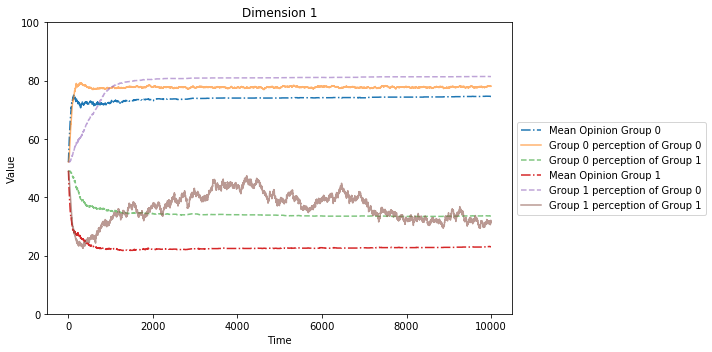

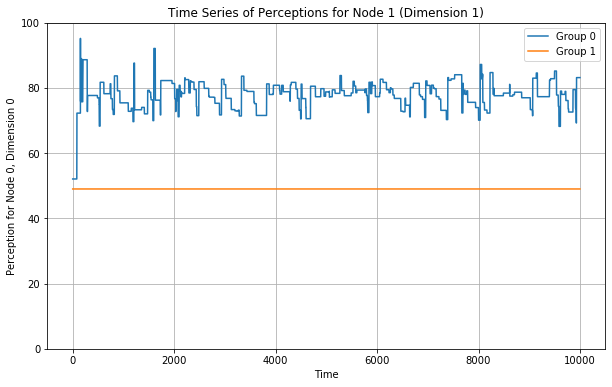

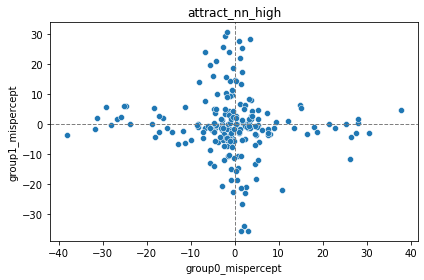

In [64]:
trial = "trial5"
simtype = "attract_nn_high"

df_in_use = df_trial5 if trial == "trial5" else df_trial6
trial_folder = "trial5_oct11" if trial == "trial5" else "trial6_oct18"

#Running the plots =========================================
folder = f"/l/nx/data/groupshift/{trial_folder}/{simtype}"
folder_contents = os.listdir(folder)
filename = folder_contents[np.random.randint(len(folder_contents))]

with open(folder+"/"+filename, 'rb') as f:
    singlesim = pickle.load(f)

#Plotting singles
singlesim.plot_group_values()
singlesim.plot_indiv_values(node_num=0)


fig, ax = plt.subplots()  # 3 rows, 4 columns of plots
# Plot the scatter plot for the current category
sns.scatterplot(data=df_in_use[df_in_use['Category'] == simtype], 
                x='group0_mispercept', 
                y='group1_mispercept')

# Plot vertical and horizontal lines at X=0 and Y=0
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Set the title to the current category name
ax.set_title(simtype)

# Lock the axis limits to the global min and max values
# if simtype not in ["attract_nn_high", "attract_nn_high_repulse"]:
#     minimum = -23; maximum = 23
#     ax.set_xlim(minimum, maximum)
#     ax.set_ylim(minimum, maximum)

# Adjust the layout
plt.tight_layout()
plt.show()

### Plot raw diff by folder

Raw differences

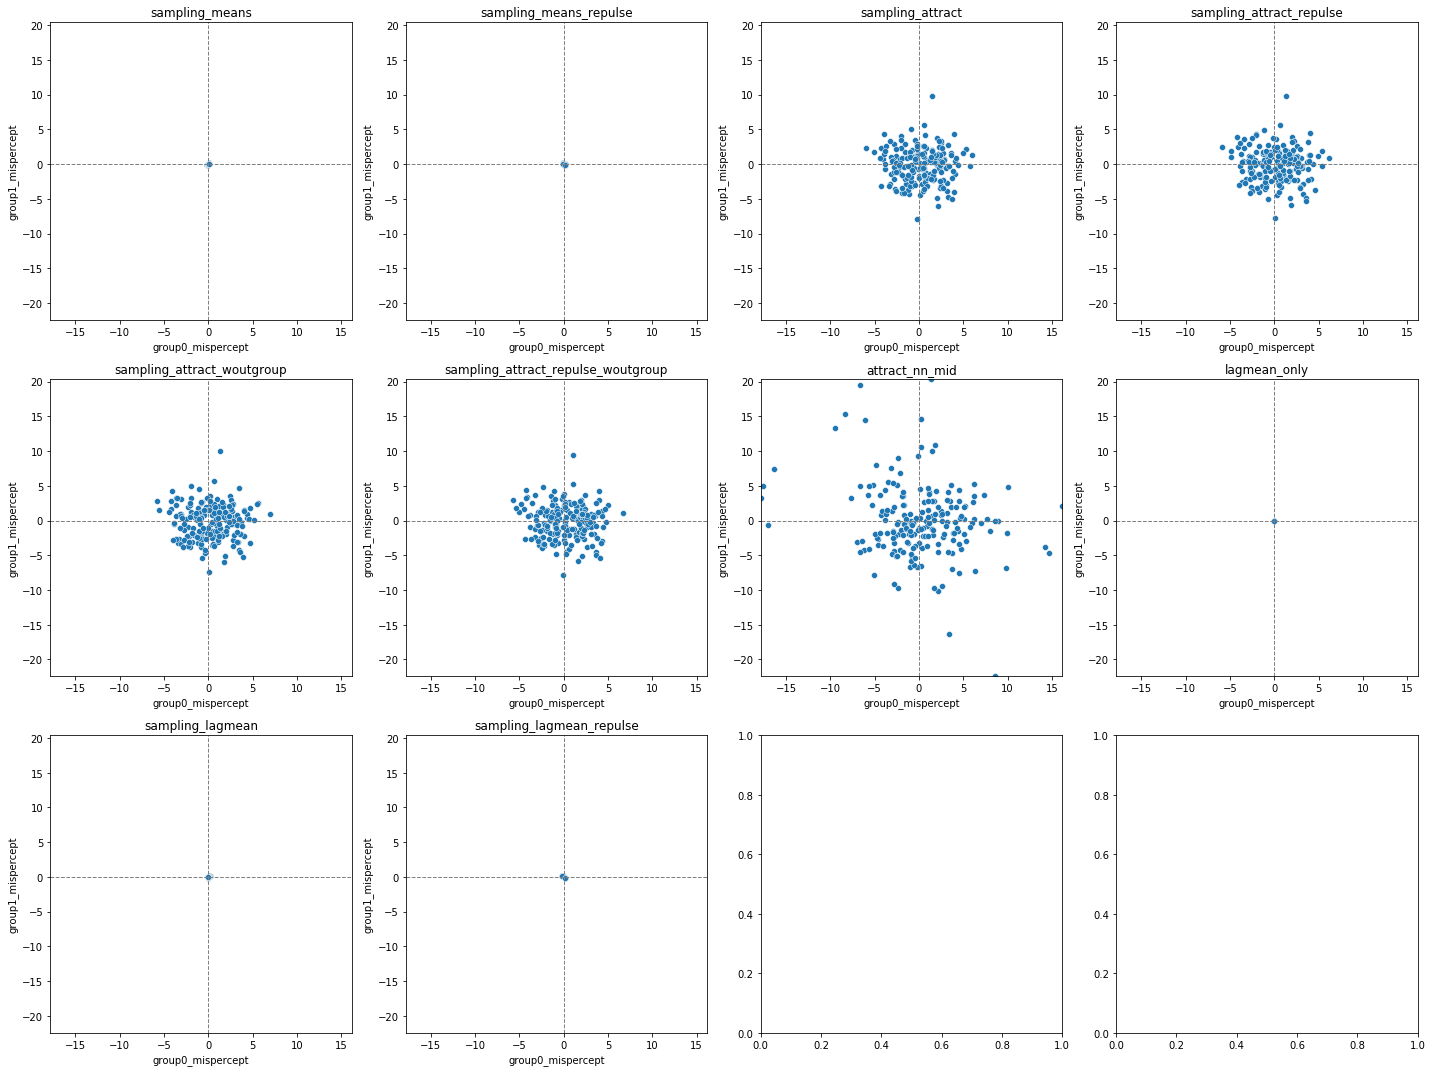

In [10]:
# Find the min and max values across all categories for x ('Grp0') and y ('Grp1')
x_min = df['group0_mispercept'].min()
x_max = df['group0_mispercept'].max()
y_min = df['group1_mispercept'].min()
y_max = df['group1_mispercept'].max()

# Create the subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows, 4 columns of plots
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, category in enumerate(simfol_list):
    # Select the current subplot
    ax = axes[i]
    
    # Plot the scatter plot for the current category
    sns.scatterplot(data=df[df['Category'] == category], 
                    x='group0_mispercept', 
                    y='group1_mispercept', 
                    ax=ax)
    
    # Plot vertical and horizontal lines at X=0 and Y=0
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    # Set the title to the current category name
    ax.set_title(category)
    
    # Lock the axis limits to the global min and max values
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Adjust the layout
plt.tight_layout()
plt.show()

### Plot RMC by folder

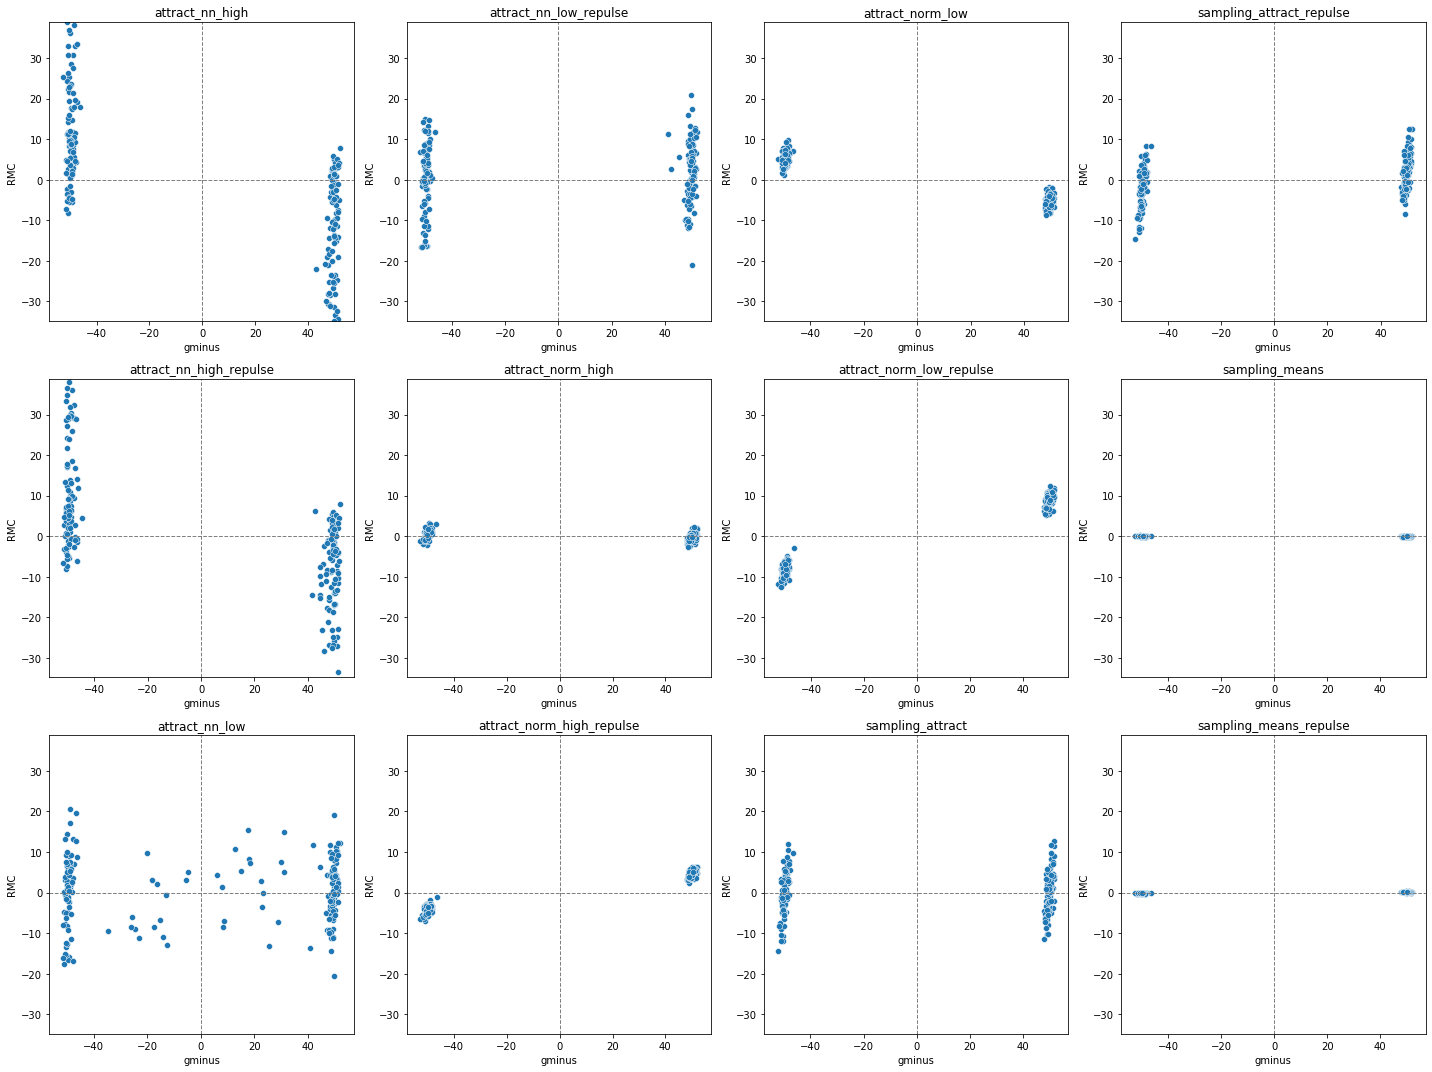

In [17]:
# Find the min and max values across all categories for x ('Grp0') and y ('Grp1')
x_min = df['group0_mispercept'].min()
x_max = df['group0_mispercept'].max()
y_min = df['RMC'].min()
y_max = df['RMC'].max()

# Create the subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows, 4 columns of plots
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, category in enumerate(simfol_list):
    # Select the current subplot
    ax = axes[i]
    
    # Plot the scatter plot for the current category
    sns.scatterplot(data=df[df['Category'] == category], 
                    x = 'gminus',
                    y = 'RMC',
                    ax=ax)
    
    # Plot vertical and horizontal lines at X=0 and Y=0
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    # Set the title to the current category name
    ax.set_title(category)
    
    # Lock the axis limits to the global min and max values
    # ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Adjust the layout
plt.tight_layout()
plt.show()

# Heatmap

In [26]:
def calculate_overperceived_polarization(sim):
    """
    Calculate overperceived polarization:
    (ingroup perception more extreme than true mean)
    """
    final_t = sim.timesteps - 1  # last timestep
    dim = 0  # since you said opinion dims is always 1

    # Compute true mean opinion for each group
    group_means = []
    group_percepts = []
    for group in range(sim.num_groups):
        group_members = np.where(sim.N_adj[:, final_t] == group)
        mean_opinion = np.mean(sim.N[group_members])
        mean_perception = np.mean(sim.G[group_members, group, dim, final_t])

        group_means.append(mean_opinion)
        group_percepts.append(mean_perception)

    # print("Group means")
    # print(group_means)
    # print("Group percepts")
    # print(group_percepts)

    # Determine which group is closer to 100
    dists_to_100 = [abs(100 - m) for m in group_means]
    dists_to_0 = [abs(0 - m) for m in group_means]

    group_up = np.argmin(dists_to_100)  # group closer to 100
    group_down = np.argmax(dists_to_100)  # closer to 0

    # print((group_down, group_up))

    up_mean = group_means[group_up]
    up_percept = group_percepts[group_up]
    down_mean = group_means[group_down]
    down_percept = group_percepts[group_down]

    group_up_discrepancy = up_percept - up_mean
    group_down_discrepancy = down_mean - down_percept

    # print(group_up_discrepancy + group_down_discrepancy)

    return group_up_discrepancy + group_down_discrepancy

In [27]:
folder = "/l/nx/data/groupshift/trial1_july4_2025/"

aWidth = 5
rWidth = 10
aAmp_list = [0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rAmp_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 3.0, 10.0]

heatmap_data = np.zeros((len(aAmp_list), len(rAmp_list)))
relevantfiles = ["simulation0.pkl", "simulation1.pkl", "simulation2.pkl", "simulation3.pkl", "simulation4.pkl"] #These are always the same filenames across parameters

for i, aAmp in enumerate(aAmp_list):
    for j, rAmp in enumerate(rAmp_list): 
        parameter_label = f"aWidth{aWidth}_aAmp{aAmp}_rWidth{rWidth}_rAmp{rAmp}"

        polvals = []
        for filename in relevantfiles:
            with open(folder + parameter_label + "/" + filename, 'rb') as f:
                singlesim = pickle.load(f)
            
                # Calculate polarization
                polvals.append(calculate_overperceived_polarization(singlesim))

                # Average across values
                heatmap_data[i, j] = np.mean(polvals)

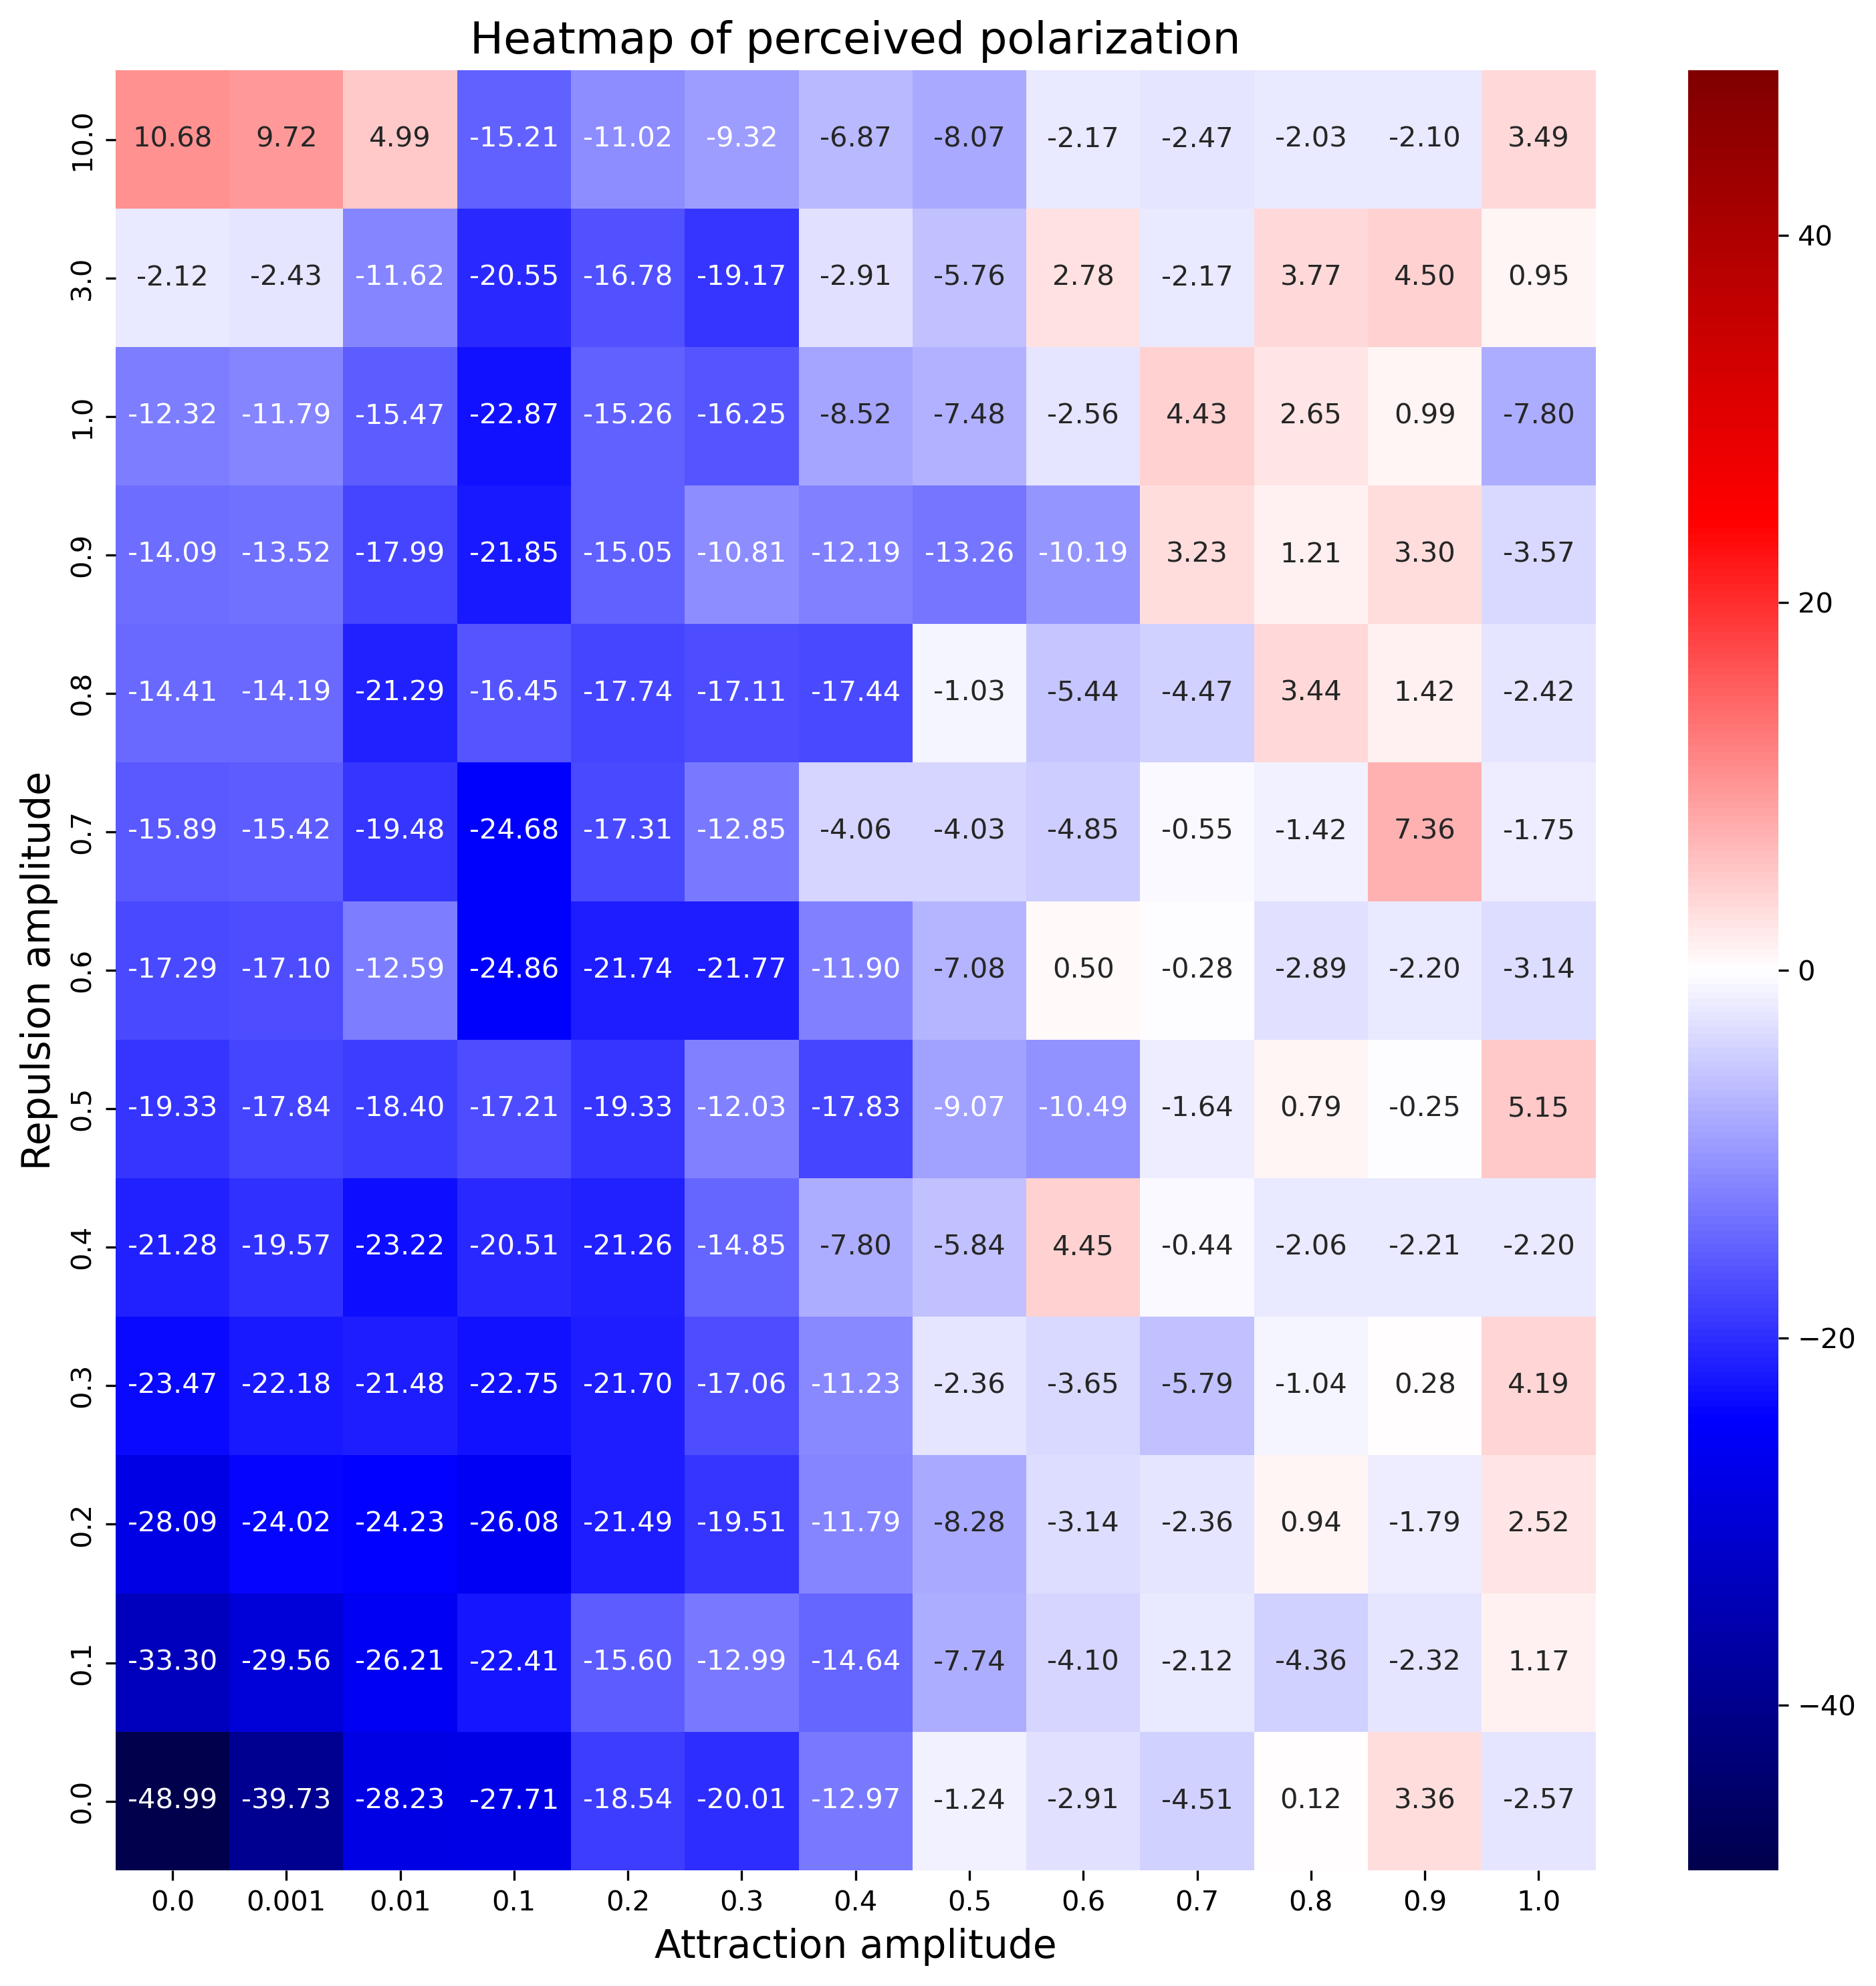

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

# Find max absolute value to force symmetry
abs_max = np.abs(heatmap_data).max()

plt.figure(figsize=(10, 10), dpi=300)  # DPI controls pixel density, not text scale

sns.heatmap(
    heatmap_data.T,
    xticklabels=aAmp_list,
    yticklabels=rAmp_list,
    cmap="seismic",
    center=0,
    vmin=-abs_max,
    vmax=abs_max,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}  # make annotation text readable
)

plt.xlabel("Attraction amplitude", fontsize=14)
plt.ylabel("Repulsion amplitude", fontsize=14)
plt.title("Heatmap of perceived polarization", fontsize=16)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("heatmap_highres.png", dpi=300, bbox_inches="tight")
plt.show()



# Visualizing sampling

## Plot single simulation

In [37]:
import numpy as np
import pickle
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from groupshift_parallel import *

/l/nx/data/groupshift/sims_2025_12_17_initmeans/proximity_aWidth1.0_aAmp1.0_rWidth1.0_rAmp1.0/simulation2.pkl


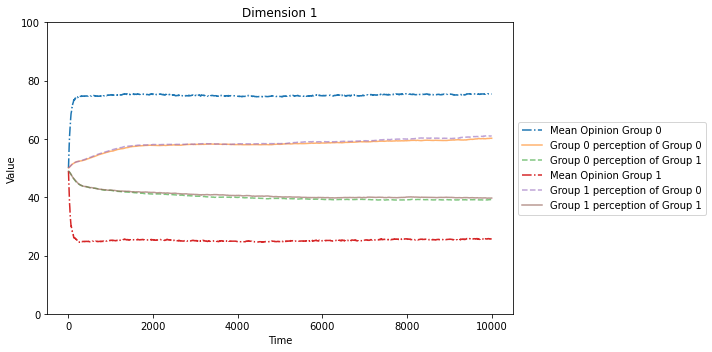

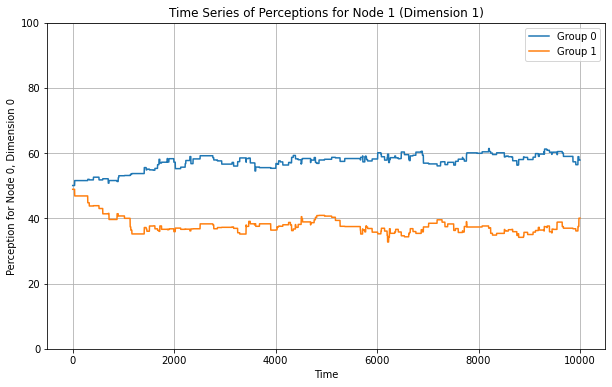

In [50]:
sampling_type = 'proximity'
init_type = 'initmeans'
aWidth = 1.0
rWidth = 1.0
aAmp = 1.0
rAmp = 1.0

parameter_label = f"{sampling_type}_aWidth{aWidth}_aAmp{aAmp}_rWidth{rWidth}_rAmp{rAmp}"
simtype = parameter_label
trial_folder = "sims_2025_12_17_" + init_type
folder = f"/l/nx/data/groupshift/{trial_folder}/{simtype}"

# Just for testing, we will use the first file in the folder
filename = os.listdir(folder)[2]
print( folder + "/" + filename )

with open(folder+"/"+filename, 'rb') as f:
    singlesim = pickle.load(f)

singlesim.plot_group_values()
singlesim.plot_indiv_values(node_num=0)

## Construct dataset

In [ ]:
dim = 0
aWidth = 1.0
rWidth = 1.0
aAmp = 1.0
rAmp = 1.0

folder = "sims_2025_12_17_initmeans/"
simfol_list = ["random", "extremity", "proximity"]

parameter_label = f"aWidth{aWidth}_aAmp{aAmp}_rWidth{rWidth}_rAmp{rAmp}"
simfol_list = [f"{sampling_type}_{parameter_label}" for sampling_type in simfol_list]

data = []
for subfol_name in simfol_list:
    print(subfol_name)
    subfolder = folder + subfol_name
    files = os.listdir(subfolder)
    for filename in tqdm(files):
        with open(subfolder+"/"+filename, 'rb') as f:
            thissim = pickle.load(f)

        thissim_data = {}
        for group in range(thissim.num_groups):
            group_members = np.where(thissim.N_adj[:, thissim.timesteps-1 ] == group)
            
            #Initial group values FOR INITIAL GROUP MEMBERS
            group_mem_init = np.where(thissim.N_adj[:, 0] == group)
            init_ingroup_perception = np.mean(thissim.G[group_mem_init, group, dim, 0])
            thissim_data[f'group{group}_percept_init'] = init_ingroup_perception

            #Mean of group members AT END
            group_mean = np.mean(thissim.N[group_members])
            thissim_data[f'group{group}_mean'] = group_mean

            #Mean of ingroup perceptions at END
            ingroup_perception = np.mean(thissim.G[group_members, group, dim, (thissim.timesteps-500):thissim.timesteps-1])
            thissim_data[f'group{group}_percept_fin'] = ingroup_perception

            #Mean of outgroup perceptions at END
            outgroup_perception = np.mean(thissim.G[group_members, 1-group, dim, (thissim.timesteps-500):thissim.timesteps-1])
            thissim_data[f'group{group}_outgroup_percept_fin'] = outgroup_perception

            thissim_data[f'group{group}_size_fin'] = len(group_members[0])
            thissim_data[f'group{group}_size_init'] = len(group_mem_init[0])

            group_vals = thissim.N[group_members]
            thissim_data[f'group{group}_var'] = np.var(group_vals)

        thissim_data['Category'] = subfol_name
        thissim_data['SimID'] = filename
        data.append(thissim_data)

df = pd.DataFrame(data)
df.head()

In [6]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Configuration
# -----------------------------

dim = 0
end_window = 500

folder = "sims_2025_12_17_initrand/"
sampling_types = ["random", "extremity", "proximity"]

aWidth = 1.0
rWidth = 1.0
aAmp = 1.0
rAmp = 1.0

parameter_label = f"aWidth{aWidth}_aAmp{aAmp}_rWidth{rWidth}_rAmp{rAmp}"
sim_folders = [f"{s}_{parameter_label}" for s in sampling_types]

rows = []

# -----------------------------
# Extraction loop
# -----------------------------

for subfol_name in sim_folders:
    print(f"Processing {subfol_name}")
    subfolder = os.path.join(folder, subfol_name)
    files = os.listdir(subfolder)

    for filename in tqdm(files):
        with open(os.path.join(subfolder, filename), "rb") as f:
            sim = pickle.load(f)

        T = sim.timesteps
        end_slice = slice(T - end_window, T)

        for group in range(sim.num_groups):

            # --- membership ---
            members_init = np.where(sim.N_adj[:, 0] == group)[0]
            members_fin  = np.where(sim.N_adj[:, T - 1] == group)[0]

            if len(members_fin) == 0:
                continue  # optional: skip extinct groups

            # --- true opinions ---
            true_vals_fin = sim.N[members_fin, dim]

            true_mean = np.mean(true_vals_fin)
            true_var  = np.var(true_vals_fin)

            # --- perceptions ---
            percept_init = np.mean(sim.G[members_init, group, dim, 0])

            percept_fin = np.mean(
                sim.G[members_fin, group, dim, end_slice]
            )

            outgroup = 1 - group
            percept_outgroup_fin = np.mean(
                sim.G[members_fin, outgroup, dim, end_slice]
            )

            # --- record row ---
            rows.append({
                "SimID": filename,
                "Category": subfol_name,
                "GroupID": group,

                "true_mean": true_mean,
                "true_var": true_var,

                "group_size_init": len(members_init),
                "group_size_fin": len(members_fin),

                "percept_init": percept_init,
                "percept_fin": percept_fin,
                "percept_outgroup_fin": percept_outgroup_fin,
            })

# -----------------------------
# Build canonical dataset
# -----------------------------

df_base = pd.DataFrame(rows)

# # Optional: store true inter-group distance (duplicated per group)
# df_base["true_group_distance"] = (
#     df_base
#     .groupby("SimID")["true_mean"]
#     .transform(lambda x: abs(x.iloc[0] - x.iloc[1]))
# )

# Save once
df_base.to_csv("sims_data_initrand.csv", index=False)

print("Base dataset saved.")


  0%|                                                                                                                                                | 0/500 [00:00<?, ?it/s]

Processing random_aWidth1.0_aAmp1.0_rWidth1.0_rAmp1.0


  0%|                                                                                                                                                | 0/500 [00:00<?, ?it/s]

Processing extremity_aWidth1.0_aAmp1.0_rWidth1.0_rAmp1.0


  0%|                                                                                                                                                | 0/500 [00:00<?, ?it/s]

Processing proximity_aWidth1.0_aAmp1.0_rWidth1.0_rAmp1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:00<00:00,  1.39it/s]

Base dataset saved.


Merge datasets

In [7]:
# Load datasets
df_initmeans = pd.read_csv("sims_data_initmeans.csv")
df_initrand  = pd.read_csv("sims_data_initrand.csv")

# Add condition label
df_initmeans["init_type"] = "initmeans"
df_initrand["init_type"]  = "initrand"

# Combine
df_all = pd.concat(
    [df_initmeans, df_initrand],
    axis=0,
    ignore_index=True
)

df_all.to_csv("sims_data_2025_12_18.csv", index=False)

In [5]:
import pandas as pd
import numpy as np

# -----------------------------
# Load base dataset
# -----------------------------

df = pd.read_csv("sims_data_2025_12_18.csv")
df.reset_index(drop=True, inplace=True)

LOW_POLE  = 0
HIGH_POLE = 100
MIDPOINT  = (LOW_POLE + HIGH_POLE) / 2

# -----------------------------
# Pull out basics
# -----------------------------

df["simnum"] = (
    df["SimID"]
    .str.extract(r"simulation(\d+)")
    .astype(int)
)

df["sampling_method"] = df["Category"].str.split("_").str[0]

# -----------------------------
# Pole labeling (absolute)
# -----------------------------

# df["pole"] = np.where(df["true_mean"] < MIDPOINT, "low", "high")
# df["pole_sign"] = np.where(df["pole"] == "high", 1, -1)

# -----------------------------
# Pole labeling (relative)
# -----------------------------

df["rank_within_sim"] = (
    df
    .groupby(["init_type", "sampling_method", "simnum"])["true_mean"]
    .rank(method="first")
)

df["pole"] = np.where(
    df["rank_within_sim"] == 1,
    "low",
    "high"
)

df["pole_sign"] = np.where(df["pole"] == "high", 1, -1)

# -----------------------------
# Signed ingroup misperception
# -----------------------------

df["signed_discrepancy"] = (
    df["pole_sign"] * (df["percept_fin"] - df["true_mean"])
)

# -----------------------------
# Reorder columns for readability
# -----------------------------

df.loc[:, ["init_type", 
           "sampling_method", 
           "simnum", 
           "GroupID", 
           "group_size_init", 
           "group_size_fin", 
           "true_mean", 
           "true_var", 
           "percept_init", 
           "percept_fin", 
           "pole", 
           "pole_sign", 
           "signed_discrepancy"]
           ].head()

,init_type,sampling_method,simnum,GroupID,group_size_init,group_size_fin,true_mean,true_var,percept_init,percept_fin,pole,pole_sign,signed_discrepancy
0,initmeans,random,13,0,516,572,71.981556,282.877958,50.471762,52.627548,high,1,-19.354008
1,initmeans,random,13,1,484,428,21.335430,160.081847,50.127241,33.570031,low,-1,-12.234601
2,initmeans,random,7,0,487,462,76.277155,205.335321,50.917612,59.234510,high,1,-17.042645
3,initmeans,random,7,1,513,538,26.722043,231.999588,48.381341,44.146811,low,-1,-17.424767
4,initmeans,random,8,0,478,586,29.818434,305.958376,50.290570,46.004030,low,-1,-16.185596


## Plot bulk simulations

### Plot pluralistic ignorance via signed, pole-oriented discrepancy

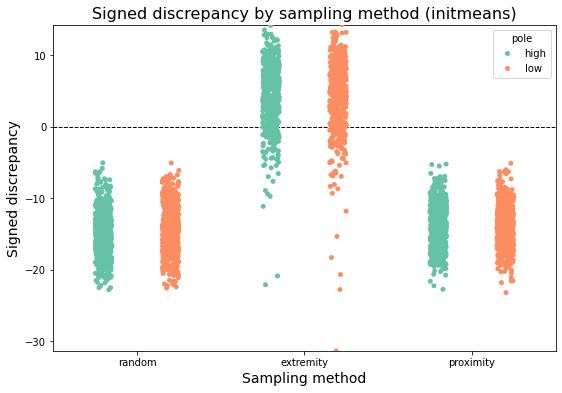

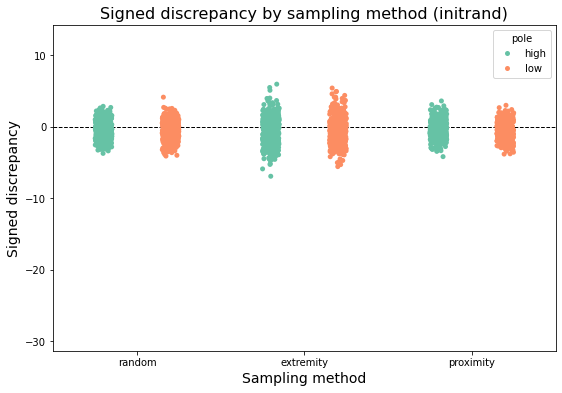

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns

# Plot signed discrepancy by sampling method

# Constrain y axis to the range of signed discrepancies
y_min = df["signed_discrepancy"].min()
y_max = df["signed_discrepancy"].max()

# Only plot for initmeans
df_initmeans = df[df["init_type"] == "initmeans"]
plt.figure(figsize=(9, 6))
plt.axhline(0, color="black", linestyle="--", linewidth=1)
sns.stripplot(data=df_initmeans, 
              x="sampling_method", 
              y="signed_discrepancy", 
              hue="pole", 
              palette="Set2", 
              dodge=True
              )
# Increase font size
plt.title("Signed discrepancy by sampling method (initmeans)", fontsize=16)
plt.xlabel("Sampling method", fontsize=14)
plt.ylabel("Signed discrepancy", fontsize=14)
plt.ylim(y_min, y_max)
plt.show()

# Only plot for initmeans
df_initrand = df[df["init_type"] == "initrand"]
plt.figure(figsize=(9, 6))
plt.axhline(0, color="black", linestyle="--", linewidth=1)
sns.stripplot(data=df_initrand, x="sampling_method", y="signed_discrepancy", hue="pole", palette="Set2", dodge=True)
plt.title("Signed discrepancy by sampling method (initrand)", fontsize=16)
plt.xlabel("Sampling method", fontsize=14)
plt.ylabel("Signed discrepancy", fontsize=14)
plt.ylim(y_min, y_max)
plt.show()

### Plot false polarization via signed, pole-oriented discrepancy

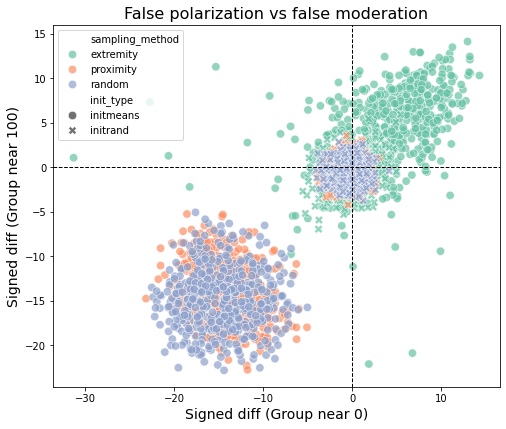

In [44]:
df_scatter = (
    df
    .set_index(["init_type", "sampling_method", "simnum", "pole"])
    ["signed_discrepancy"]
    .unstack("pole")
    .reset_index()
    .rename(columns={
        "low": "low_group_discrepancy",
        "high": "high_group_discrepancy"
    })
)

plt.figure(figsize=(8, 8))
# Reference lines
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)

sns.scatterplot(
    data=df_scatter,
    x="low_group_discrepancy",
    y="high_group_discrepancy",
    hue="sampling_method",
    style="init_type",
    alpha=0.7, 
    # bigger markers for readability
    s=70, 
    palette="Set2"
)

# Labels
plt.xlabel("Signed diff (Group near 0)", fontsize=14)
plt.ylabel("Signed diff (Group near 100)", fontsize=14)
plt.title("False polarization vs false moderation", fontsize=16)

plt.gca().set_aspect("equal", adjustable="box") # Set equal aspect ratio for evaluation
plt.show()